### Libraries

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install pyyaml

import os
import re
import gc
import sys
import time
import yaml
import errno
import hashlib
import base64
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from abc import ABC, abstractmethod
from IPython.display import display, clear_output
from ipywidgets import widgets
from tensorflow.test import gpu_device_name
from tensorflow.image import random_contrast, random_saturation
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D, concatenate, add, Dense, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, ReLU, Add
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import utils
from matplotlib import pyplot as plt
from scipy import optimize
from copy import deepcopy
from functools import partial


ON_COLAB = 'google.colab' in sys.modules

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=70d26a30133820a3ad5927c1f2cb95091f12fd21229ee9d268cbd45abe601c95
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
''' PRELIMINARY CONFIGURATIONS / TESTS '''

def test_colab_GPU_mem():
    '''
        Colab GPU memory test
    '''

    import psutil
    import humanize
    import GPUtil as GPU
    GPUs = GPU.getGPUs()

    gpu = GPUs[0]

    process = psutil.Process(os.getpid())
    print('Gen RAM Free: ' + humanize.naturalsize(psutil.virtual_memory().available), ' | Proc size: ' + humanize.naturalsize(process.memory_info().rss))
    print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    # Check if GPU usage is > 2% (i.e device shared with other Colab users)
    print('GPU Memory is shared! Restart the runtime.' if gpu.memoryUtil > 0.05 else 'GPU Memory is free!')


if ON_COLAB:
    from google.colab import files, drive #, output
    # output.enable_custom_widget_manager()
    drive.mount('/content/gdrive')


    if gpu_device_name() != '/device:GPU:0':
        print('GPU device not found -- Try enabling GPU acceleration in Colab\'s runtime settings')

    else:
        print('GPU device found!')
        test_colab_GPU_mem()



Mounted at /content/gdrive
GPU device found!
Gen RAM Free: 87.0 GB  | Proc size: 1.3 GB
GPU RAM Free: 39934MB | Used: 602MB | Util   1% | Total 40536MB
GPU Memory is free!


### Helper Tools

#### Prompt Handler

In [3]:
class PromptHandler:
    '''
        Wrapper for input prompt-handling methods
    '''

    @staticmethod
    def setup_ipy_widgets(on_yaml_export, on_yaml_init):
        ''' Sets up configuration loader/exporter IPython widgets '''

        path_textarea = widgets.Text(placeholder='/path/to/config.yaml',
                                     value='/content/config.yaml')
        export_btn = widgets.Button(description="Export *Form* Config")
        load_btn = widgets.Button(description="Load Config")
        output = widgets.Output()

        def on_export_click(b):
            path = path_textarea.value

            filename = os.path.basename(path)
            path = os.path.dirname(path)

            with output:
                clear_output(wait=True)
                if filename == '':
                    print('\nInvalid path / filename!\n\n')
                on_yaml_export(path, filename)

        def on_load_click(b):
            path = path_textarea.value

            with output:
                clear_output(wait=True)
                on_yaml_init(path)


        export_btn.on_click(on_export_click)
        load_btn.on_click(on_load_click)

        bot_box = widgets.HBox([load_btn, export_btn])
        cont_box = widgets.VBox([path_textarea, bot_box])

        display(cont_box, output)


    @staticmethod
    def prompt_yes_no(question, default='y'):
        '''
            Yes/no query; reverts to default value if no input is given
        '''

        valid_res = {
            'yes': True,
            'y': True,
            'no': False,
            'n': False
        }

        choice = None

        while choice not in valid_res:
            choice = input(f'{question} (y/n): ').lower().replace(' ', '') or default

        return valid_res[choice]



#### File Handler

In [4]:
class FileHandler:
    '''
        Wrapper for file-handling methods
    '''
    
    __VALID_PATHS = {}

    @staticmethod
    def __path_exists(path):
        ''' Checks if file exists '''

        return os.path.exists(path)


    @staticmethod
    def validate_path(path, ignore_abs_format=True):
        ''' 
            Ensures that a given path is universaly valid
            (Windows/Linux/MacOS/POSIX)
        '''

        # Directory already exists, prompt for overwrite permission (first time only)
        if path not in FileHandler.__VALID_PATHS and FileHandler.__path_exists(path):

            FileHandler.__VALID_PATHS[path] = True
            
            if len(os.listdir(path)) == 0:
                # directory exists and is empty -> is valid
                return FileHandler.__VALID_PATHS[path]

            # directory exists and is NOT empty
            FileHandler.__VALID_PATHS[path] = True
            print(f'\nPath ({path}) already exists!\n\n')
            return PromptHandler.prompt_yes_no('Would you like to overwrite files in this path?')

        # Previously evaluated
        if path in FileHandler.__VALID_PATHS:
            return FileHandler.__VALID_PATHS[path]
        
        # Check the validity of the given path
        try:
            os.makedirs(path)
            FileHandler.__VALID_PATHS[path] = True
        except OSError as e:
            # path invalid
            print('\nBase path and/or config version are invalid! Please choose path-friendly names.\n')
            FileHandler.__VALID_PATHS[path] = False

        return FileHandler.__VALID_PATHS[path]


    @staticmethod
    def create_dir(path):
        ''' Recursively creates new directory if it does not exist '''

        if not FileHandler.__path_exists(path):
            os.makedirs(path)


    @staticmethod
    def path_must_exist(path):
        ''' 
            Checks if file exists and raises error if it does not.
            Used when the logic of the algorithm depends on the loaded file
        '''

        if not FileHandler.__path_exists(path):
            raise FileNotFoundError(errno.ENOENT, 
                                    os.strerror(errno.ENOENT), 
                                    path)


    @staticmethod
    def save_pickle(p_dict, path, filename, force_dir=True):
        ''' Saves the given dictionary as pickle '''

        if not FileHandler.__path_exists(path):
            if force_dir:
                FileHandler.create_dir(path)
            else:
                # directory does not exist and cannot create dir
                return False
        
        # dump pickle
        with open(os.path.join(path, filename), 'wb') as handle:
            pickle.dump(p_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return True


    @staticmethod
    def load_pickle(path, default_dict={}):
        ''' Loads pickle and returns decoded dictionary '''

        res = default_dict

        if FileHandler.__path_exists(path):
            with open(path, 'rb') as handle:
                res = pickle.load(handle)

        return res


    @staticmethod
    def save_df(df, path, filename, force_dir=True):
        ''' Saves the given dataframe to a given path+filename '''

        if not FileHandler.__path_exists(path):
            if force_dir:
                FileHandler.create_dir(path)
            else:
                # directory does not exist and cannot create dir
                return False

        # save dataframe
        df.to_csv(os.path.join(path, filename))


    @staticmethod
    def load_df(path, default_df=None):
        ''' Loads dataframe if it exists or defaults to an empty df '''

        res = default_df or pd.DataFrame()

        if FileHandler.__path_exists(path):
            res = pd.read_csv(path, header=0, index_col=0)

        return res

    
    @staticmethod
    def export_yaml(config_dict, path, filename, file_version_comment='', force_dir=True):
        ''' Exports a given dictionary to a yaml file '''
        
        if not FileHandler.__path_exists(path):
            if force_dir:
                FileHandler.create_dir(path)
            else:
                return False
            
        with open(os.path.join(path, filename), 'w') as handler:
            if file_version_comment:
                handler.write(f'\n# {file_version_comment}\n\n')
            yaml.dump(config_dict, handler, default_flow_style=False)

        return True

    
    @staticmethod
    def load_yaml(path, loader, default_dict={}):
        ''' Loads a yaml config file and returns it as dict '''

        res = default_dict

        if FileHandler.__path_exists(path):
            with open(path, 'r') as handler:    
                res = yaml.load(handler, Loader=loader)

        return res



#### Operational Parameters

In [5]:
class Params:
    '''
        Wrapper for all global operational parameters
        and the configuration loader
    '''

    @staticmethod
    def config_form():
        '''
            Facilitates the notebook's form and returns a config dict
        '''


        ''' Configuration Version (used as filenames) '''
        CONFIG_VERSION = 'act_res_aug_cutout_2'   #@param {type:"string"}


        #@markdown ## ABC Optimizer Parameters
        #@markdown ---


        ''' Optimization problem (NAS or Numerical Benchmarks to test ABC) '''
        OPTIMIZATION_OBJECTIVE = 'HiveNAS'  #@param ['HiveNAS', 'Sphere_max', 'Sphere_min', 'Rosenbrock']

        ''' Max trials per Scout (i.e initial Food Source) '''
        ABANDONMENT_LIMIT = 5  #@param {type:"slider", min:1, max:50, step:1}

        ''' Number of bees in the colony (Employees + Onlookers) '''
        COLONY_SIZE = 7    #@param {type:"slider", min:1, max:50, step:1}

        ''' Distribution of Employees to Onlookers, resulting number of EmployeeBees = # of ScoutBees '''
        EMPLOYEE_ONLOOKER_RATIO = 0.43   #@param {type:"slider", min:0.1, max:1.0, step:0.05}

        ''' Number of ABC optimization iterations '''
        ITERATIONS_COUNT = 20    #@param {type:"slider", min:1, max:100, step:1}


        #@markdown \
        #@markdown ## File-Handling Parameters
        #@markdown ---


        ''' Save results every N evaluations (not iterations) '''
        RESULTS_SAVE_FREQUENCY = 1   #@param {type:"slider", min:1, max:100, step:1}

        '''
            Result files base path (path will be created if it does not exist) 
            A local folder will be created after the CONFIG_VERSION
        '''
        RESULTS_BASE_PATH = '/content/gdrive/MyDrive/PhD/HiveNAS/'  #@param {type:"string"}

        ''' Training history files sub-path '''
        HISTORY_FILES_SUBPATH = 'training_history/'     #@param {type:"string"}

        ''' Enable weights saving for resumed training '''
        ENABLE_WEIGHT_SAVING = False    #@param {type:"boolean"}

        ''' Weight files sub-path (ensure that the path exists) '''
        WEIGHT_FILES_SUBPATH = 'weights/'    #@param {type:"string"}

        ''' Specifies whether or not to resume from existing results file (if exists)'''
        RESUME_FROM_RESULTS_FILE = False   #@param {type:'boolean'}


        #@markdown \
        #@markdown ## NAS Search Space Parameters
        #@markdown ---


        ''' -- NAS Search Space configuration -- '''

        #@markdown *( layers & hyperparameters must be defined as partial functions in code )*
        
        ''' Number of layers for sampled networks (excludes input/output stems) '''
        DEPTH = 5     #@param {type:"slider", min:1, max:10, step:1}

        ''' Search space operations '''
        OPERATIONS = {
            'sep5x5_128': partial(SeparableConv2D, filters=128, kernel_size=(5,5), activation='relu', padding='same'),
            'sep3x3_128': partial(SeparableConv2D, filters=128, kernel_size=(3,3), activation='relu', padding='same'),
            'sep5x5_64': partial(SeparableConv2D, filters=64, kernel_size=(5,5), activation='relu', padding='same'),
            'sep3x3_64': partial(SeparableConv2D, filters=64, kernel_size=(3,3), activation='relu', padding='same'),
            'sep5x5_32': partial(SeparableConv2D, filters=32, kernel_size=(5,5), activation='relu', padding='same'),
            'sep3x3_32': partial(SeparableConv2D, filters=32, kernel_size=(3,3), activation='relu', padding='same'),
            'max_pool3x3': partial(MaxPooling2D, pool_size=(3,3), strides=(1,1), padding='same'),
            'avg_pool3x3': partial(AveragePooling2D, pool_size=(3,3), strides=(1,1), padding='same'),
            'batch_norm': partial(BatchNormalization),
            'dropout': partial(Dropout, rate=0.2)
        }

        ''' '''

        # Skip-Connections'/Residual Blocks' occurence rate (0.0 = disabled)
        RESIDUAL_BLOCKS_RATE = 0.15    #@param {type:"slider", min:0.0, max:1.0, step:0.05}


        #@markdown \
        #@markdown ## NAS Evaluation Strategy Parameters
        #@markdown ---


        ''' -- NAS Evaluation Strategy configuration -- '''

        ''' Dataset (classes/inputs are inferred internally) '''
        DATASET = 'CIFAR10'   #@param ["CIFAR10", "MNIST"]

        ''' Static output stem, added to every candidate '''
        OUTPUT_STEM = [
            partial(Flatten),
            partial(Dropout, rate=0.15),
            partial(Dense, units=1024, activation='relu'),
            partial(Dropout, rate=0.15),
            partial(Dense, units=512, activation='relu')
        ]

        ''' Static input stem, added to every candidate '''
        INPUT_STEM = [
            partial(Conv2D, filters=32, kernel_size=(3,3)),
            partial(BatchNormalization),
            partial(ReLU)
        ]

        ''' Epochs count per candidate network '''
        EPOCHS = 3  #@param {type:"slider", min:1, max:25, step:1}
        
        ''' Momentum Augmentation epochs (0 = disabled ; overrides ENABLE_WEIGHT_SAVING) '''
        MOMENTUM_EPOCHS = 10 #@param {type:"slider", min:0, max:25}

        ''' Epochs count for the best performing candidate upon full training '''
        FULL_TRAIN_EPOCHS = 50 #@param {type:"slider", min:1, max:150, step:1}

        ''' 
            Threshold factor (beta) for early-stopping (refer to the TerminateOnThreshold class for details)
                1.0 = all networks will be terminated (minimum accuracy = 100%)
                0.0 = disable early-stopping, all networks will pass
                0.25 = for 10 classes, val_acc > 0.325 at epoch 1 will not be terminated
                       (tolerance decreased for every subsequent epoch)
        '''
        TERMINATION_THRESHOLD_FACTOR = 0.25 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

        ''' Diminishing factor (zeta) for termination threshold over epochs '''
        TERMINATION_DIMINISHING_FACTOR = 0.25 #@param {type:"slider", min:0.1, max:1.0, step:0.05}

        ''' Learning rate (overrides default optimizer lr) '''
        LR = 0.001  #@param {type:"slider", min:0.001, max:0.1, step:0.001}

        ''' Batch size for every candidate evaluation '''
        BATCH_SIZE = 128     #@param {type:"slider", min:8, max:256, step:2}

        ''' Optimizer used for both NAS and full-training methods '''
        OPTIMIZER = 'Adam'    #@param ["Adam", "RMSprop"]


        #@markdown \
        #@markdown ## Data Augmentation Parameters
        #@markdown ---


        ''' 
            Enable affine transformations augmentation 
            (horizontal/vertical shifts, rotation, etc...)
        '''

        AFFINE_TRANSFORMATIONS_ENABLED = True   #@param {type:"boolean"}

        ''' Probability of random cutout augmentation occurence (0.0 = disabled) '''
        CUTOUT_PROB = 0.5    #@param {type:"slider", min:0.0, max:1.0, step:0.05}

        ''' Probability of random saturation augmentation occurence (0.0 = disabled) '''
        SATURATION_AUG_PROB = 0.5    #@param {type:"slider", min:0.0, max:1.0, step:0.05}

        ''' Probability of random contrast augmentation occurence (0.0 = disabled) '''
        CONTRAST_AUG_PROB = 0.5    #@param {type:"slider", min:0.0, max:1.0, step:0.05}

        return locals()


    ''' Main configuration dict '''
    __CONFIG = config_form.__func__()


    @staticmethod
    def init_from_yaml(path):
        ''' Initializes the global parameters from a given yaml config file '''

        def param_op_constructor(loader: yaml.SafeLoader, node: yaml.nodes.MappingNode):
            # constructs an operation partial function from yaml !Operation tags
            op_dict = loader.construct_mapping(node)
            op = op_dict['op']
            del op_dict['op']

            return partial(globals()[op], **op_dict)
            
 
        def param_tuple_constructor(loader: yaml.SafeLoader, node: yaml.nodes.MappingNode):
            # because for some reason we need an explicit tuple constructor

            return tuple(loader.construct_sequence(node))

        # register constructors
        loader = yaml.SafeLoader
        loader.add_constructor(u'tag:yaml.org,2002:python/tuple', param_tuple_constructor)
        loader.add_constructor('!Operation', param_op_constructor)

        config = FileHandler.load_yaml(path, loader)

        if not config:
            print(f'\nConfig file ({path}) is either invalid or does not exist.\n\n')
            return

        for key,val in config.items():
            Params.__CONFIG[key] = val

        print(f'\nSuccessfully loaded the operational parameters from {path}.\n\n')


    @staticmethod
    def export_yaml(path, filename, from_formdata=False):
        ''' Saves the current configurations to the given path as yaml '''

        def param_op_representer(dumper, data):
            # serialize partial functions into yaml !Operation
            serialized_data = {'op': data.func.__name__}
            serialized_data.update(data.keywords)
            
            return dumper.represent_mapping('!Operation', serialized_data, flow_style=True)

        def param_tuple_representer(dumper, data):
            # serialize tuples into yaml !!python/tuple

            return dumper.represent_sequence(u'tag:yaml.org,2002:python/tuple', data, flow_style=True)

        # register representers
        yaml.add_representer(tuple, param_tuple_representer)
        yaml.add_representer(partial, param_op_representer)
        yaml.Dumper.ignore_aliases = lambda *args : True

        # data source (changing the Colab form does not reflect on the main dict)
        data = Params.config_form() if from_formdata else Params.__CONFIG

        if FileHandler.export_yaml(Params.config_form(),
                                   path,
                                   filename):
            print(f'\nConfiguration file saved successfully to ({os.path.join(path, filename)})!\n\n')
        else:
            print('\nFailed to save config file!\n\n')


    @staticmethod
    def search_space_config():
        '''  Returns the search space config dict '''

        res = {
            'depth': Params['DEPTH'],
            'operations': Params['OPERATIONS'],
            'residual_blocks_rate': Params['RESIDUAL_BLOCKS_RATE']
        }

        return res
    

    @staticmethod
    def evaluation_strategy_config():
        '''  Returns the evaluation strategy config dict '''

        res = {
            'dataset': Params['DATASET'],
            'operations': Params['OPERATIONS'],
            'output_stem': Params['OUTPUT_STEM'],
            'input_stem': Params['INPUT_STEM'],
            'epochs': Params['EPOCHS'],
            'full_train_epochs': Params['FULL_TRAIN_EPOCHS'],
            'lr': Params['LR'],
            'batch_size': Params['BATCH_SIZE'],
            'optimizer': globals()[Params['OPTIMIZER']],
            'termination_threshold_factor': Params['TERMINATION_THRESHOLD_FACTOR'],
            'termination_diminishing_factor': Params['TERMINATION_DIMINISHING_FACTOR'],
            'momentum_epochs': Params['MOMENTUM_EPOCHS']
        }

        return res


    @staticmethod
    def get_results_path():
        '''  Gets the results path from RESULTS_BASE_PATH and CONFIG_VERSION '''

        path = os.path.join(Params.__CONFIG['RESULTS_BASE_PATH'],
                            f'{Params.__CONFIG["CONFIG_VERSION"]}/')

        if FileHandler.validate_path(path):
            return path

        return None


    def __class_getitem__(cls, key):
        ''' Subscript operator definition '''
            
        return Params.__CONFIG[key]


''' Init widgets if ran on Colab '''
if ON_COLAB:
    PromptHandler.setup_ipy_widgets(on_yaml_export=lambda p, f: Params.export_yaml(p, f, True),
                                    on_yaml_init=lambda p: Params.init_from_yaml(p))


Output()

#### Logger

In [6]:
class Logger:
    '''
        Wrapper for debug- and info-logging methods
    '''

    __DEBUG_PREFIX  = 'DEBUG:'
    __STATUS_PREFIX = 'STATUS:'
    __EVAL_PREFIX = 'EVALUATION LOG:'
    __FILESAVE_PREFIX = 'FILE-SAVE SUCCESSFUL:'

    __START_TIME = None

    EVALUATION_LOGGING = False


    @staticmethod
    def debug(msg=None):
        ''' Debugging messages '''

        print('{} {}'.format(Logger.__DEBUG_PREFIX,
                            ('MARK' if msg is None else str(msg))))

    
    @staticmethod
    def status(itr, msg=None):
        ''' Generic logging '''

        print('{} itr: {} -- {}'.format(Logger.__STATUS_PREFIX,
                                        str(itr),
                                        ('MARK' if msg is None else str(msg))))


    @staticmethod
    def evaluation_log(type, id, candidate_pos):
        ''' Logs pre-evaluation info for every candidate '''

        if not Logger.EVALUATION_LOGGING:
            return

        print('\n{} {} ID ({}) -- Candidate ({})\n'.format(Logger.__EVAL_PREFIX,
                                                           type,
                                                           str(id),
                                                           str(candidate_pos)))


    @staticmethod
    def filesave_log(candidate, filename):
        ''' Logs candidate info upon file-save '''

        if not Logger.EVALUATION_LOGGING:
            return

        print('\n{} Candidate ({}) was saved to {}\n'.format(Logger.__FILESAVE_PREFIX,
                                                             str(candidate),
                                                             filename))
        

    @staticmethod
    def start_log():
        ''' Logs the start msg and intializes the global timer '''

        Logger.__START_TIME = time.time()
        dashes = '------------------------'
        print('{}\n-- OPTIMIZATION START --\n{}'.format(dashes, dashes))


    @staticmethod
    def end_log():
        ''' Logs total time taken upon optimization end '''

        end_time = time.time() - Logger.__START_TIME
        dashes = '---------------------'
        print('{}\n-- OPTIMIZATION END --\n{} === TOTAL TIME TAKEN: {} ==== \n'.format(dashes, dashes, end_time))



#### Image Augmentations

In [7]:
class ImgAug:
    ''' 
        Element-wise image augmentation methods, used to preprocess a
        given dataset.
        (most affine transformations are already implemented in 
        Keras' ImageDataGenerator)
    '''

    @staticmethod
    def random_cutout(np_tensor):
        '''
            Randomly applies cutout augmentation to a given rank 3 tensor as
            defined in [1].

            [1] DeVries, T., & Taylor, G. W. (2017). Improved regularization of 
            convolutional neural networks with cutout.
        '''

        cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
        cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])

        cutout_height_point = np.random.randint(np_tensor.shape[0] - cutout_height)
        cutout_width_point = np.random.randint(np_tensor.shape[1] - cutout_width)

        np_tensor[cutout_height_point: cutout_height_point + cutout_height, 
                  cutout_width_point: cutout_width_point + cutout_width, 
                  :] = 127    # 127 = grey cutout,
                              # 0 (black) or 255 (white) also valid
        
        return np.array(np_tensor)


    @staticmethod
    def random_contrast(np_tensor):
        ''' Apply random contrast augmentation '''
        
        return np.array(random_contrast(np_tensor, 0.5, 2))

    @staticmethod
    def random_saturation(np_tensor):
        ''' Apply random saturation augmentation '''

        return np.array(random_saturation(np_tensor, 0.2, 3))

    @staticmethod
    def augment(np_tensor):
        ''' Used by ImageDataGenerator's preprocess_function '''

        if np.random.uniform() <= Params['CONTRAST_AUG_PROB']:
            np_tensor = ImgAug.random_contrast(np_tensor)
        if np.random.uniform() <= Params['SATURATION_AUG_PROB']:
            np_tensor = ImgAug.random_saturation(np_tensor)
        if np.random.uniform() <= Params['CUTOUT_PROB']:
            np_tensor = ImgAug.random_cutout(np_tensor)

        return np_tensor



### NAS Components

#### NAS Search Space

In [8]:
class NASSearchSpace(object):
    ''' Defines the Search Space used to sample candidates by HiveNAS '''
         
    def __init__(self, config):
        '''
            Configurations are predefined in the Params class,
            the implementation should work given any set of operations' mapping
            and depth
        '''

        self.config = config
        # self.__initialize_graph()
                    

    def sample(self):
        '''
            Samples a random point in the search space
        '''

        # assert self.all_paths != None, 'Search space needs to be initialized!'

        # idx = np.random.randint(0, len(self.all_paths))
        # return self.__encode_path(self.all_paths[idx])

        path = ['input']

        for l in range(self.config['depth']):

            if np.random.rand() < self.config['residual_blocks_rate']:
                sc_depth = np.random.randint(1, self.config['depth'] - l + 1)
                path.append('L{}_sc_{}'.format(l+1, sc_depth))

            path.append('L{}_{}'.format(l+1, np.random.choice(
                list(self.config['operations'].keys())
            )))
        
        path.append('output')

        return self.__encode_path(path)


    def get_neighbor(self, path_str):
        ''' Returns a path with 1-op difference (a neighbor)'''

        path = self.__strip_path(self.__decode_path(path_str))

        component = np.random.randint(1, len(path) - 1)

        ops = []
        if path[component].startswith('sc'):
            # modify skip-connection (either remove it or change residual depth)
            sc_max_depth = len([op for op in path[component:] if not op.startswith('sc')])
            ops = [f'sc_{i}' for i in range(sc_max_depth)]
            ops.remove(path[component])
        else:
            # modify operation
            ops = list(self.config['operations'].keys())
            ops.remove(path[component])
        
        # Replace randomly chosen component (operation) with any other op
        path[component] = np.random.choice(ops)

        # prune skip-connection if op == sc_0
        if path[component] == 'sc_0':
            del path[component]

        return self.__encode_path(path)


    def eval_format(self, path):
        ''' 
            Formats a path for evaluation (stripped, decoded, and
            excluding input/output layers) given a string-encoded path
        '''

        return self.__strip_path(self.__decode_path(path))[1:-1]


    def __initialize_graph(self):
        '''
            Initializes the search space DAG for easier sampling by the
            search algorithm
            [Deprecated] -- The search space DAG-representation is too memory-expensive
        '''
        
        self.dag = nx.DiGraph()
        self.dag.add_node('input')

        for l in range(self.config['depth']):
            for op in self.config['operations']:
                # Connect input layer to first hidden layer
                if l == 0:
                    self.dag.add_edges_from([('input', 
                                              'L{}_{}'.format(l+1, op))])
                    continue

                # Densely connect middle layers
                for prev_op in self.config['operations']:
                    self.dag.add_edges_from([('L{}_{}'.format(l, prev_op), 
                                              'L{}_{}'.format(l+1, op))])

                # Connect last hidden layer to output stem
                if l == self.config['depth'] - 1:
                    self.dag.add_edges_from([('L{}_{}'.format(l+1, op), 
                                              'output')])

        self.all_paths = list(nx.all_simple_paths(self.dag, 'input', 'output'))


    def __encode_path(self, path):
        ''' Returns a string encoding of a given path (list of ops)'''

        return '|'.join(self.__strip_path(path))


    def __decode_path(self, path):
        ''' Returns a list of ops given a string-encoded path '''

        ops = path.split('|')

        for i in range(1, len(ops) - 1):
            ops[i] = 'L{}_{}'.format(i, ops[i])

        return ops


    def __strip_path(self, path):
        ''' Strips path of layer ID prefixes given a list of ops '''
        
        return [re.sub('L\d+_', '', s) for s in path]


    def compute_space_size(self):
        ''' 
            Returns the number of possible architectures in the given space
            (i.e operations and depth) for analytical purposes
        '''

        return len(list(self.config['operations'].keys())) ** \
        self.config['depth']

        

#### NAS Evaluation Strategy

In [9]:
class NASEval(object):
    ''' Responsible for instantiating and evaluating candidate architectures '''

    def __init__(self, config):
        ''' 
            Initializes the evaluation parameters' configuration ;
            for a different dataset, a data-loader must be specified below
            as with CIFAR10 Keras loader
        '''
        
        self.config = config

        # specify dataset loaders
        if config['dataset'] == 'CIFAR10':
            (self.X_train, self.y_train), (self.X_test, self.y_test) = cifar10.load_data()
        elif config['dataset'] == 'MNIST':
            (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
            # Add a placeholder dimension to the dataset to match RGB image datasets
            self.X_train = self.X_train.reshape(-1,28,28,1)
            self.X_test = self.X_test.reshape(-1,28,28,1) 
        elif config['dataset'] == 'IMAGE_NET':
            pass
        else:
            pass

        if Params['ENABLE_WEIGHT_SAVING']:
            # create directory if it does not exist
            FileHandler.create_dir(os.path.join(Params.get_results_path(),
                                                Params['WEIGHT_FILES_SUBPATH']))

        self.__initialize_dataset()


    def __instantiate_network(self, arch):
        ''' Instantiates a Keras network given an architecture op list '''

        # residual counters
        res_count = []

        # add input according to given dataset shape
        net = inputs = Input(shape=(self.X_train.shape[1:4]))

        # add input stem
        for op in self.config['input_stem']:
            net = op()(net)

        # add hidden layers
        for layer in arch:

            if layer.startswith('sc'):
                # start residual block
                res_count.append((net, int(layer[3:])))
                continue

            assert layer in self.config['operations'], 'Operation must be defined as a partial in HIVE_EVAL_CONFIG'
            net = self.config['operations'][layer]()(net)

            for idx, row in enumerate(res_count):
                connection, counter = row
                counter -= 1

                # apply pooling to residual blocks to maintain shape
                # [deprecated] -- pooling layers padded
                # if 'pool' in layer:
                #     connection = self.config['operations'][layer]()(connection)

                if counter == 0:
                    # conv1x1 to normalize channels
                    fx = Conv2D(net.shape[-1], (1, 1), padding='same')(connection)
                    net = Add()([fx, net])
                    del res_count[idx]
                else:
                    res_count[idx] = (connection, counter)

        # add output stem
        for op in self.config['output_stem']:
            net = op()(net)

        # add output layer
        net = Dense(len(np.unique(self.y_test)), activation='softmax')(net)

        self.model = Model(inputs, net)


    def get_weights_filename(self, arch):
        ''' 
            Hashes the architecture op-list into a filename
        '''

        return hashlib.sha1(''.join(arch).encode("UTF-8")).hexdigest()


    def evaluate(self, arch):
        '''
            Evaluates the candidate architecture given a string-encoded
            representation of the model
        '''

        # instantiate/compile model
        self.__instantiate_network(arch)
        self.__compile_model()
        
        # train model
        # self.model.fit(x=self.X_train,
        #         y=self.y_train,
        #         batch_size=self.config['batch_size'],
        #         epochs=self.config['epochs'],
        #         verbose=1,
        #         validation_data=(self.X_test, self.y_test))
        
        assert self.config['epochs'] > 2 or self.config['momentum_epochs'] == 0, 'Momentum Augmentation requires at least 3 epochs per candidate'

        cb = []
        if self.config['termination_threshold_factor'] > 0.0:
            cb.append(TerminateOnThreshold(threshold_multiplier=self.config['termination_threshold_factor'],
                                           diminishing_factor=self.config['termination_diminishing_factor']))
        if self.config['momentum_epochs'] > 0:
            cb.append(MomentumAugmentation())

        history = self.model.fit(self.datagen.flow(self.X_train,
                                                   self.y_train,
                                                   shuffle=True,
                                                   batch_size=self.config['batch_size'],
                                                   subset='training'),
                                 validation_data=self.datagen.flow(self.X_train,
                                                                   self.y_train,
                                                                   batch_size=int(self.config['batch_size'] / 2), 
                                                                   subset='validation'),
                                 epochs=self.config['epochs'],
                                 verbose=1,
                                 callbacks=cb)

        momentum = self.model.momentum if hasattr(self.model, 'momentum') else {}
        # test model
        eval_res = self.model.evaluate(self.X_test,
                                      self.y_test,
                                      batch_size=self.config['batch_size'],
                                      verbose=1)
        
        # dump training history
        hist_path = os.path.join(Params.get_results_path(), Params['HISTORY_FILES_SUBPATH'])
        hist_fn = self.get_weights_filename(arch) + '.pickle'

        FileHandler.save_pickle(history.history, hist_path, hist_fn)
        
        # save weights for later retraining when needed
        filename = self.get_weights_filename(arch) + '.h5'

        if Params['ENABLE_WEIGHT_SAVING']:
            model_path = os.path.join(Params.get_results_path(), Params['WEIGHT_FILES_SUBPATH'])
            self.model.save(model_path + filename)

        trainable_params = np.sum([K.count_params(w) for w in self.model.trainable_weights])

        # housekeeping
        del self.model
        
        # return validation accuracy to maximize + additional data for saving purposes
        retval = {
            'fitness': eval_res[1], 
            'epochs': len(history.history['loss']),
            'filename': filename,
            'params': trainable_params,
            'momentum': momentum
        }

        return retval

    
    def fully_train(self, model_file=None, arch=None):
        ''' Loads and continues training of a partially-trained model '''

        hist_path = os.path.join(Params.get_results_path(), Params['HISTORY_FILES_SUBPATH'])
        hist_fn = ''

        if model_file is not None:
            # load model
            self.model = tf.keras.models.load_model(model_file)
            hist_fn =  model_file.split('/')[-1] + '.full.pickle'
        else:
            # instantiate network
            self.__instantiate_network(arch)
            self.__compile_model()
            model_file = self.get_weights_filename(arch)
            hist_fn = model_file + '.full.pickle'
        
        # continue training
        # self.model.fit(x=self.X_train,
        #                y=self.y_train,
        #                batch_size=self.config['batch_size'],
        #                epochs=self.config['full_train_epochs'],
        #                verbose=1,
        #                validation_data=(self.X_test, self.y_test))
        
        history = self.model.fit(self.datagen.flow(self.X_train, 
                                                   self.y_train,
                                                   shuffle=True,
                                                   batch_size=self.config['batch_size'],
                                                   subset='training'),
                                 validation_data=self.datagen.flow(self.X_train,
                                                                   self.y_train,
                                                                   batch_size=int(self.config['batch_size'] / 2), 
                                                                   subset='validation'),
                                  epochs=self.config['full_train_epochs'],
                                  verbose=1)

        
        # test model
        eval_res = self.model.evaluate(self.X_test,
                                       self.y_test,
                                       batch_size=self.config['batch_size'],
                                       verbose=1)
        
        # dump training history
        FileHandler.save_pickle(history.history, hist_path, hist_fn)
        
        # save weights for later retraining when needed
        # if Params['ENABLE_WEIGHT_SAVING']: 
        # Save fully trained model regardless of params
        self.model.save(model_file + '.full.h5')

        trainable_params = np.sum([K.count_params(w) for w in self.model.trainable_weights])

        # housekeeping
        del self.model
        
        retval = {
            'fitness': eval_res[1], 
            'epochs': len(history.history['loss']),
            'filename': model_file,
            'params': trainable_params
        }

        return retval

    
    def __initialize_dataset(self):
        ''' 
            Prepares the dataset (Normalization -> One-Hot Encoding)
            and initializes the ImageGenerator for evaluation
        '''

        # Standardize data
        X_train_mean = np.mean(self.X_train, axis=(0,1,2))
        X_train_std = np.std(self.X_train, axis=(0,1,2))
        self.X_train = (self.X_train - X_train_mean) / X_train_std
        self.X_test = (self.X_test - X_train_mean) / X_train_std

        # Affine transformations
        if Params['AFFINE_TRANSFORMATIONS_ENABLED']:
            self.datagen = ImageDataGenerator(
                zoom_range = [0.8, 1.1], 
                shear_range= 10,
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                preprocessing_function=ImgAug.augment,
                validation_split=0.2
            )
        else:
            self.datagen = ImageDataGenerator(preprocessing_function=ImgAug.augment,
                                              validation_split=0.2)

        # per docs, .fit() is only needed if the generator enables:
        # featurewise_center or featurewise_std_normalization or zca_whitening
        # self.datagen.fit(self.X_train)

        # # One-hot encoding
        # deprecated; memory consumption too high for intermediate tensors
        # self.y_train = utils.to_categorical(self.y_train)
        # self.y_test = utils.to_categorical(self.y_test)


    def __compile_model(self):
        ''' Compiles model in preparation for evaluation '''

        self.model.compile(loss='sparse_categorical_crossentropy', \
                           optimizer=self.config['optimizer'](), \
                           metrics=['sparse_categorical_accuracy'])
        



##### Adaptive Cutoff Threshold

In [10]:
class TerminateOnThreshold(Callback):
    """
        Adaptive Cutoff Threshold (ACT)

        Keras Callback that terminates training if a given 'sparse_categorical_accuracy'
        dynamic threshold is not reached after n_epochs.
        The termination threshold has a logarithmic nature where the threshold
        increases by a decaying factor.
    """

    def __init__(self, 
                monitor='val_sparse_categorical_accuracy', 
                threshold_multiplier=0.25,
                diminishing_factor=0.25,
                n_classes = None):
        ''' Initialize threshold-based termination callback '''
        
        super(TerminateOnThreshold, self).__init__()

        self.monitor = monitor
        self.beta = threshold_multiplier
        self.zeta = diminishing_factor
        self.n_classes = n_classes

    def get_threshold(self, epoch):
        ''' Calculates val_acc termination threshold given the current epoch '''
        '''
            ΔThreshold = ß(1 - (1 / n))
            Threshold_base = (1 / n) + ΔThreshold = (1 / n) + ß(1 - (1 / n))
                                                  = (1 + ßn - ß) / n

            Range of Threshold_base = (1 / n, 1) ; horizontal asymptote at 1
            ΔThreshold decays as the number of classes decreases
            
            --------------

            To account for the expected increase in accuracy over the number
            of epochs ε, a growth_factor is added to the base threshold:

            growth_factor = (1 - Threshold_base) - (1 / (1 / 1-Threshold_base) + ζ(ε - 1))
            
            Threshold_adaptive = Threshold_base + growth_factor

            Range of growth_factor = [Threshold_base, 1) ; horizontal asymptote at 1
        '''

        baseline = 1.0 / self.n_classes     # baseline (random) val_acc
        complement_baseline = 1 - baseline
        delta_threshold = complement_baseline * self.beta
        base_threshold = baseline + delta_threshold
        ''' n_classes = 10, threshold_multiplier = 0.15 '''
        ''' yields .325 acc threshold for epoch 1 '''

        # epoch-based decaying increase in val_acc threshold
        complement_threshold = 1 - base_threshold    # the increase factor's upper limit
        growth_denom = (1.0 / complement_threshold) + self.zeta * (epoch - 1)
        growth_factor = complement_threshold - 1.0 / growth_denom

        calculated_threshold = base_threshold + growth_factor
        ''' 
            Same settings as before yields:
            epoch 1 = .325000
            epoch 2 = .422459, 
            epoch 3 = .495327,
            epoch 4 = .551867,
            epoch 5 = .597014
        '''
        
        return calculated_threshold


    def on_epoch_end(self, epoch, logs=None):
        ''' Called by Keras backend after each epoch during .fit() & .evaluate() '''

        logs = logs or {}

        if self.model is None:
            return

        if self.n_classes is None:
            self.n_classes = self.model.layers[-1].output_shape[1]

        threshold = self.get_threshold(epoch + 1)

        if self.monitor in logs:
            val_acc = logs[self.monitor]
            if val_acc < threshold:
                # threshold not met, terminate
                print(f'\nEpoch {(epoch + 1)}: Accuracy ({val_acc}) has not reached the baseline threshold {threshold}, terminating training... \n')
                self.model.stop_training = True

                

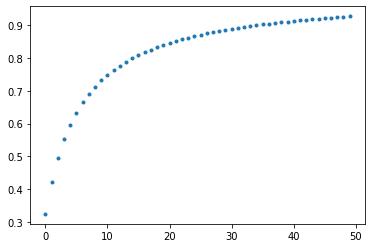




Epoch 1 threshold: 0.325
Epoch 2 threshold: 0.4224598930481284
Epoch 3 threshold: 0.4953271028037383
Epoch 4 threshold: 0.5518672199170125
Epoch 5 threshold: 0.5970149253731344


In [11]:
''' TESTING THRESHOLD EVAL '''
threshold_multiplier = 0.25
diminishing_factor = 0.25
n_classes = 10
n_epochs = 50

thresholds = []
for epoch in range(1, n_epochs + 1):

    baseline = 1.0 / n_classes     # baseline (random) val_acc
    complement_baseline = 1 - baseline
    delta_threshold = complement_baseline * threshold_multiplier
    base_threshold = baseline + delta_threshold

    # epoch-based decaying increase in val_acc threshold
    complement_threshold = 1 - base_threshold    # the increase factor's upper limit
    growth_denom = (1.0 / complement_threshold) + diminishing_factor * (epoch - 1)
    growth_factor = complement_threshold - 1.0 / growth_denom

    calculated_threshold = base_threshold + growth_factor

    thresholds.append(calculated_threshold)

plt.plot(thresholds, '.')
plt.show()

# print first 5 thresholds
print('\n\n')
[print(f'Epoch {t+1} threshold: {thresholds[t]}') for t in range(0, 5)];



##### Momentum Augmentation

In [12]:
class MomentumAugmentation(Callback):
    ''' Calculates the momentum's moving average of the parent model '''

    def __init__(self, monitor='val_sparse_categorical_accuracy'):
        ''' Initialize MA '''

        super(MomentumAugmentation, self).__init__()
        self.monitor = monitor

    
    def get_momentum(self, epoch, acc):
        ''' Calculates the momentums based on the given accuracies and epochs '''

        if epoch < 2:
            # momentum = acc at ε < 3
            return acc

        delta_1 = acc - self.model.momentum[epoch - 1][0]
        delta_2 = self.model.momentum[epoch - 1][0] - self.model.momentum[epoch - 2][0]

        if delta_2 == 0.0:
            # avoid division by 0
            # if previous 2 accuracies are somehow exactly the same (very unlikely) => 0 momentum
            return 0.0

        current_momentum = delta_1 / delta_2

        return (acc, current_momentum)

    
    def on_epoch_end(self, epoch, logs=None):
        ''' Called by Keras backend after each epoch during .fit() & .evaluate() '''

        logs = logs or {}

        if self.model is None:
            return

        if not hasattr(self.model, 'momentum'):
            self.model.momentum = {}

        if self.monitor in logs:
            val_acc = logs[self.monitor]
            
            self.model.momentum[epoch] = self.get_momentum(epoch, val_acc)
            
    

#### NAS Interface

In [13]:
class HiveNAS(object):
    ''' 
        An interface that combines the Search Space + Evaluation Strategy 
        for the Artificial Bee Colony algorithm
    '''

    search_space = None
    eval_strategy = None

    def __init__(self, 
                 space_config=None,
                 eval_config=None):
        ''' Initializes the search space and evaluator '''

        space_config = space_config or Params.search_space_config()
        eval_config = eval_config or Params.evaluation_strategy_config()

        HiveNAS.search_space = NASSearchSpace(space_config)
        HiveNAS.eval_strategy = NASEval(eval_config)


    def sample(self):
        ''' Samples new random candidate architecture from the search space '''

        return HiveNAS.search_space.sample()


    def evaluate(self, candidate):
        ''' Evaluates a given candidate architecture; returns loss value '''

        formatted = HiveNAS.search_space.eval_format(candidate)
        res = HiveNAS.eval_strategy.evaluate(formatted)

        # housekeeping
        K.clear_session()
        gc.collect()
        
        return res


    def get_neighbor(self, orig_arch):
        ''' Returns a random architecture with 1 op diff to the given candidate '''

        return HiveNAS.search_space.get_neighbor(orig_arch)


    def fully_train_best_model(self, from_arch=True):
        '''
            Fully-train best-performing model
            (relies on paths set in Params)
        '''

        # check existence of results file
        filename = f'{Params["CONFIG_VERSION"]}.csv'
        results_file = os.path.join(Params.get_results_path(), filename)
        FileHandler.path_must_exist(results_file)    # breaks if file does not exist

        # extract best fitness weight file
        results_df = pd.read_csv(results_file, header=0, index_col=0)
        weight_file = results_df.loc[results_df['fitness'] == results_df['fitness'].max(), 'weights_filename'].values[0]
        arch = results_df.loc[results_df['fitness'] == results_df['fitness'].max(), 'candidate'].values[0]

        print(f'\nFound best-performing model {{{arch}}} with a fitness score of {results_df["fitness"].max()}\n')
        
        # housekeeping -> results_df no longer needed and is potentially large
        del results_df
        gc.collect()

        if from_arch:
            # Retrains from scratch given the network arch
            arch = formatted = HiveNAS.search_space.eval_format(arch)
            return HiveNAS.eval_strategy.fully_train(arch=arch)

        # check existence of weight file
        weight_file = os.path.join(Params.get_results_path(), Params['WEIGHT_FILES_SUBPATH'], weight_file)
        FileHandler.path_must_exist(weight_file)    # breaks if file does not exist
        

        # Continues training from saved h5 model (often results in lower fitness)
        return HiveNAS.eval_strategy.fully_train(model_file=weight_file)


    @property 
    def is_minimize(self):
        ''' 
            Used by the ABC algorithm to determine whether this is 
            a minimization or maximization problem (we're maximizing accuracy)
        '''

        return False



In [14]:
interface = HiveNAS()


11501568/11490434 [==============================] - 0s 0us/step


In [15]:
ss = interface.sample()
ss

'input|sep3x3_32|sep5x5_64|sep5x5_128|sep5x5_64|output'

In [16]:
interface.evaluate(ss)

ValueError: ignored

In [6]:
momentum = {0: (0.33500000834465027, 1.0), 1: (0.4878999888896942, 1.0), 2: (0.5139999985694885, 0.1706998888211455), 3: (0.5547999739646912, 1.5632168683365857), 4: (0.5895000100135803, 0.8504915925260406)}
sum([x[1] for k,x in momentum.items()]) / len(momentum)

0.9168816699367544

### Numerical Optimization Benchmarks

#### NumericalBenchmark Base Class

In [17]:
class NumericalBenchmark(ABC):
    ''' Abstract class for Numerical Optimization Benchmarks '''

    def __init__(self, dim, minv, maxv, minimization):
        self.dim = dim
        self.minv = minv
        self.maxv = maxv
        self.minimization = minimization


    def sample(self):
        ''' Samples a random point from the objective function '''

        return np.random.uniform(low=self.minv, high=self.maxv, \
                                 size=self.dim)
        

    def get_neighbor(self, pos):
        ''' Finds a random neighbor by nudging 1 component of the pos by phi '''

        op = np.random.choice(pos)
        phi = np.random.uniform(low=-1, high=1, size=len(pos))
        neighbor_pos = pos + (pos - op) * phi

        return self.__eval_boundary(neighbor_pos)
    

    def __eval_boundary(self, n_pos):
        '''
            Ensures the newly sampled position (neighbor) lies within the
            Search Space boundaries
        '''

        if (n_pos < self.minv).any() or \
        (n_pos > self.maxv).any():
            n_pos[n_pos < self.minv] = self.minv
            n_pos[n_pos > self.maxv] = self.maxv
        return n_pos


    @property
    def minimum(self):
        return self.minv


    @property
    def maximum(self):
        return self.maxv


    @property 
    def is_minimize(self):
        return self.minimization


    @abstractmethod
    def evaluate(self, pos):
        raise NotImplementedError()



#### Sphere

In [18]:
class Sphere(NumericalBenchmark):
    ''' Sphere optimization benchmark -- [ Σ Xi^2 , for i=1 in dim ] '''
    
    def __init__(self, dim, is_minimization=True):
        super(Sphere, self).__init__(dim, -100.0, 100.0, is_minimization)
        
    
    def evaluate(self, pos):
        return {
            'fitness': sum(np.power(pos, 2)),
            'epochs': 1,
            'filename': '',
            'params': self.dim
        }

        

#### Rosenbrock

In [19]:
class Rosenbrock(NumericalBenchmark):
    ''' 
        -- Rosenbrock optimization benchmark -- 
        [ Σ { 100(Xi+1 - Xi)^2 + (Xi - 1)^2 } , for i=1 in dim - 1 ] 
    '''

    def __init__(self, dim):
        super(Rosenbrock, self).__init__(dim, -30.0, 30.0, True)


    def evaluate(self, pos):
        ''' Scipy implementation '''

        return {
            'fitness': optimize.rosen(pos),
            'epochs': 1,
            'filename': '',
            'params': self.dim
        }

        

### Artificial Bee Colony Components

#### FoodSource

In [20]:
class FoodSource:
    
    def __init__(self, position=None, fitness=None):
        ''' 
            Data structure containing a FoodSource (position on the 
            optimization surface) and its fitness value
        '''

        self.pos = position
        self.fit = fitness
        self.eval_time = 0.0


    def encode_position(self):
        ''' Returns a stripped string-encoded position hash for dicts '''

        return str(self.pos).replace(' ', '')


    # --- Setters & Getters --- #

    @property
    def position(self):
        return self.pos
    

    @property
    def fitness(self):
        return self.fit


    @property
    def time(self):
        return self.eval_time


    @position.setter
    def position(self, value):
        self.pos = value


    @fitness.setter
    def fitness(self, value):
        self.fit = value


    @time.setter
    def time(self, value):
        self.eval_time = value


    def __str__(self):
        ''' For logging/debugging purposes '''

        return 'position: {}, fitness: {}, evaluation time: {}'.format(self.pos, 
                                                                       self.fit,
                                                                       self.eval_time)


    def __repr__(self):
        ''' For logging/debugging purposes '''

        return str(self)
        


#### ArtificialBee Base Class

In [21]:
class ArtificialBee(ABC):
    ''' 
        Abstract class for Employee & Onlooker Bees
    '''

    def __init__(self, food_source, id):
        self.food_source = food_source
        self.id = id if id is not None else -1
    

    def get_random_neighbor(self, obj_interface):
        '''
            Finds a random neighbor in the vicinity of the parent 
            Parent(Onlooker) = Employee,
            Parent(Employee) = Scout
            Given by [1]:

                Xmi = Li + rand(0, 1) ∗ (Ui − Li)   => Initial FoodSource
                                                       (Scout)
                υmi = Xmi + ϕmi(Xmi − Xki)          => Neighboring FoodSource 
                                                       (Employee/Onlooker)

                Where υmi is a neighboring FoodSource
                (definition of "neighboring" given in [2]; 
                TLDR - in numerical and continuous optimization problems, 
                a dimensional component is incremented/decremented. 
                In NAS context, it is a 1-operation difference per network)


            [1] Karaboga, D., & Basturk, B. (2007). A powerful and efficient 
            algorithm for numerical function optimization: artificial bee 
            colony (ABC) algorithm. Journal of global optimization, 39(3), 
            459-471.

            [2] White, C., Nolen, S., & Savani, Y. (2021, December). 
            Exploring the loss landscape in neural architecture search. 
            In Uncertainty in Artificial Intelligence (pp. 654-664). PMLR.
        '''
        
        pos = self.get_center_fs().position
        neighbor_pos = obj_interface.get_neighbor(pos)

        return FoodSource(neighbor_pos)


    def is_evaluated(self):
        ''' 
            Checks if food source is evaluated for
            solution tracking purposes
        '''

        return self.food_source is not None and \
        self.food_source.fitness is not None

    @abstractmethod
    def get_center_fs(self):
        raise NotImplementedError()


    @abstractmethod
    def evaluate(self, obj_interface):
        raise NotImplementedError()


    @abstractmethod
    def search(self, obj_interface):
        raise NotImplementedError()


    def __repr__(self):
        ''' For logging/debugging purposes '''
        return str(self)

        

#### EmployeeBee

In [22]:
class EmployeeBee(ArtificialBee):

    id_tracker = 0

    def __init__(self, food_source):
        super(EmployeeBee, self).__init__(food_source, EmployeeBee.id_tracker)
        EmployeeBee.id_tracker += 1
        self.trials = 0
        self.center_fs = food_source   # center_fs can be greedy-selected by
                                       # child onlookers (i.e the new
                                       # optimization center)


    def search(self, obj_interface):
        ''' 
            Explore new random position (near previously-sampled position)
        '''
        
        if self.food_source.fitness is None:
            # unevaluated (first iteration after abandonment reset)
            return

        # find neighbor near food_source in the bee's memory
        self.food_source = self.get_random_neighbor(obj_interface)


    def reset(self, new_fs):
        ''' Resets EmployeeBee once abandonment limit is reached '''

        self.trials = 0
        self.food_source = new_fs
        self.center_fs = new_fs


    def calculate_fitness(self):
        '''
            Calculate fitness of an EmployeeBee; given by:

                         ⎧ 1 / (1 + Fm(Xm→))       if  Fm(Xm→)≥0
            Fit_m(Xm→)=  ⎨
                         ⎩ 1 + abs(Fm(Xm→))        if  Fm(Xm→)<0
        '''

        fitm = 0
        if self.center_fs.fitness >= 0:
            fitm = 1 / (1 + self.center_fs.fitness)
        else:
            fitm = 1 + np.abs(self.center_fs.fitness)
        
        return fitm
    

    def compute_probability(self, sum_fitness):
        '''
            Calculate probability of an EmployeeBee being chosen by
            an OnlookerBee based on Fitess values; given by:

                Pn = Fit_n(Xn→) / [∑ (Fit_m(Xm→)) for all m]
        '''

        return self.calculate_fitness() / sum_fitness

    
    def evaluate(self, obj_interface, itr):
        ''' Evaluates sampled position and increments trial counter '''

        Logger.evaluation_log('EmployeeBee', self.id, self.food_source.position)
        t = time.time()

        res = obj_interface.evaluate(self.food_source.position)
        # unpack
        self.food_source.fitness = res['fitness']
        epochs = res['epochs']
        weights_filename = res['filename']
        params = res['params']
        momentum = res['momentum']

        self.food_source.time = time.time() - t
        # ACT early bandonment (ACT enabled and network could not pass epoch 1)
        abandon_early = Params['TERMINATION_THRESHOLD_FACTOR'] > 0.0 and epochs <= 1
        self.trials += 1 if not abandon_early else Params['ABANDONMENT_LIMIT']

        if self.center_fs.fitness is None:
            # Check if this evaluation is the first in its area 
            # (Iteration 1 after reset; i.e no need to greedy-select)
            self.center_fs = deepcopy(self.food_source)
        else:
            # Greedy select for iterations 2 ... Abandonment Limit
            self.greedy_select(self.food_source, obj_interface.is_minimize)

        # save data
        series = pd.Series({
            'bee_type': type(self).__name__,
            'bee_id': self.id,
            'bee_parent': '-',
            'itr': itr,
            'candidate': self.food_source.position,
            'fitness': self.food_source.fitness,
            'center_fitness': self.center_fs.fitness,
            'momentum': sum([x[1] for _,x in momentum.items()]),
            'epochs': epochs,
            'params': params,
            'weights_filename': weights_filename,
            'time': self.food_source.time
        })
        return series


    def greedy_select(self, n_food_source, is_minimize):
        ''' Update best FoodSource to minimize or maximize fitness '''

        if ((self.center_fs.fitness < n_food_source.fitness) and not is_minimize) or \
        ((self.center_fs.fitness > n_food_source.fitness) and is_minimize):
            self.center_fs.position = n_food_source.position
            self.center_fs.fitness = n_food_source.fitness
        

    def get_center_fs(self):
        ''' Returns the center food_source '''

        return self.center_fs
        

    def __str__(self):
        ''' For logging/debugging purposes '''

        return 'EmployeeBee {} -- FS: {}, trials: {}'.format(self.id, \
                                                             self.food_source, \
                                                             self.trials)
        


#### OnlookerBee

In [23]:
class OnlookerBee(ArtificialBee):

    id_tracker = 0

    def __init__(self):
        super(OnlookerBee, self).__init__(None, OnlookerBee.id_tracker)
        OnlookerBee.id_tracker += 1
        self.employee = None


    def search(self, obj_interface):
        ''' 
            Exploit position (near a random EmployeeBee chosen according 
            to computed probability)
        '''

        self.food_source = self.get_random_neighbor(obj_interface)


    def assign_employee(self, employee):
        ''' Assigns an EmployeeBee to the Onlooker for neighbor-search '''

        self.employee = employee
        self.food_source = FoodSource(self.employee.food_source.position)

    
    def evaluate(self, obj_interface, itr):
        ''' 
            Evaluates sampled position and increments employee's trial counter
        '''

        Logger.evaluation_log('OnlookerBee', self.id, self.food_source.position)
        t = time.time()
        
        res = obj_interface.evaluate(self.food_source.position)
        # unpack
        self.food_source.fitness = res['fitness']
        epochs = res['epochs']
        weights_filename = res['filename']
        params = res['params']
        momentum = res['momentum']

        self.food_source.time = time.time() - t
        self.employee.trials += 1
        self.employee.greedy_select(self.food_source, obj_interface.is_minimize)

        series = pd.Series({
            'bee_type': type(self).__name__,
            'bee_id': self.id,
            'bee_parent': self.employee.id,
            'itr': itr,
            'candidate': self.food_source.position,
            'fitness': self.food_source.fitness,
            'center_fitness': self.get_center_fs().fitness,
            'momentum': sum([x[1] for _,x in momentum.items()]) / len(momentum),
            'epochs': epochs,
            'params': params,
            'weights_filename': weights_filename,
            'time': self.food_source.time
        })
        return series
        

    def get_center_fs(self):
        ''' Returns the parent's center food_source '''
        
        return self.employee.center_fs


    def __str__(self):
        ''' For logging/debugging purposes '''

        return 'OnlookerBee {} -> Parent Employee ({}) -- FS: {}'\
        .format(self.id, self.employee.id, self.food_source)

        

#### ScoutBee

In [24]:
class ScoutBee:
    ''' 
        Scout Bees static class, 
        responsible for initializing random FoodSources position
        and reseting employed bees when abandonment limit is reached
    '''


    @staticmethod
    def sample(obj_interface):
        ''' Sample a random point from the objective function '''

        return FoodSource(obj_interface.sample())


    @staticmethod
    def check_employee_trials(employees, obj_interface):
        ''' Check if EmployeeBees reached abandonment limit '''

        for employee in employees:
            if employee.trials >= Params['ABANDONMENT_LIMIT']:
                # Reset EmployeeBees to a new ScoutBee position
                employee.reset(ScoutBee.sample(obj_interface))

        

#### ABC Algorithm

In [25]:
class ArtificialBeeColony:
    '''
        Main ABC optimizer
    '''
    
    def __init__(self, obj_interface, \
                 colony_size=Params['COLONY_SIZE'], \
                 employee_onlooker_ratio=Params['EMPLOYEE_ONLOOKER_RATIO']):
        ''' Initializes the ABC algorithm '''

        self.obj_interface = obj_interface    # Encapsulates the Search Space + 
                                              # Evaluation Strategy
        self.colony_size = colony_size
        self.eo_colony_ratio = employee_onlooker_ratio
        self.scouts_count = int(self.colony_size * self.eo_colony_ratio)


    def __init_scouts(self):
        ''' 
            Instantiate Scout bees and sample random positions 
            (does not evaluate fitness) 
        '''

        for _ in range(self.scouts_count):
            self.scouts.append(ScoutBee.sample(self.obj_interface))
    

    def __init_employees(self):
        ''' Instantiate Employee bees and assign a Scout position to each '''

        # Floor of (colony_size * ratio)
        employee_count = int(self.colony_size * self.eo_colony_ratio)
        
        for itr in range(employee_count):
            # Split scouts evenly among employees
            scout = self.scouts[int(itr / (employee_count / \
                                           self.scouts_count))]
            self.employees.append(EmployeeBee(scout))


    def __init_onlookers(self):
        ''' 
            Instantiate Onlooker bees (assigning Employees occurs after 
            evaluation and probability calculation) 
        '''

        onlooker_count = self.colony_size - int(self.colony_size * self.eo_colony_ratio)
        
        for itr in range(onlooker_count):
            self.onlookers.append(OnlookerBee())

    
    def __employee_bee_phase(self, itr):
        ''' 
            Evaluate Scout-initialized position after reset()
            or Search + Evaluate neighbor every subsequent iteration
            until abandonment limit
        '''
        
        # Search and evaluate new or existing neighbor
        for employee in self.employees:
            # Ignored if unevaluated position exists (i.e Scout-sampled)
            employee.search(self.obj_interface)

            fs = employee.food_source
            
            if fs is None or fs.encode_position() not in self.results_df['candidate']:
                # Evaluate employee position
                series = employee.evaluate(self.obj_interface, itr)
                self.__save_results(series)
            else:
                # Already evaluated
                fs.fitness = self.results_df[self.results_df['candidate'] == fs.encode_position()]['fitness'].values[0]
                employee.greedy_select(fs, self.obj_interface.is_minimize)
                # resampling the same candidate should count as a trial towards the abandonment limit?
                # onlooker.employee.trials += 1     # to avoid being stuck


    def __onlooker_bee_phase(self, itr):
        ''' 
            Assign each Onlooker to an Employee, 
            then Search + Evaluate a random neighbor
        '''

        # Calculate Employee probability
        sum_fitness = sum([employee.calculate_fitness() \
                        for employee in self.employees])
        
        # Sum(probabilities) ≈ 1.0
        probabilities = list(map(lambda employee: \
                                 employee.compute_probability(sum_fitness), \
                                 self.employees))

        if not self.obj_interface.is_minimize:
            # inverse weights to maximize the objective
            # (assign more onlookers to higher fitness scores)

            # reciprocals
            probabilities = [1.0 / prob for prob in probabilities]

            # normalize
            sum_probs = sum(probabilities)
            probabilities = [prob / sum_probs for prob in probabilities]

        # Assign EmployeeBees to OnlookerBees, search, and evaluate neighbor
        for onlooker in self.onlookers:
            # Assign EmployeeBees to OnlookerBees
            emp_idx = np.random.choice(len(self.employees), p=probabilities)

            onlooker.assign_employee(self.employees[emp_idx])

            # Search for a new random neighbor
            onlooker.search(self.obj_interface)

            fs = onlooker.food_source
            
            if fs is None or fs.encode_position() not in self.results_df['candidate']:
                # Evaluate employee position
                series = onlooker.evaluate(self.obj_interface, itr)
                self.__save_results(series)
            else:
                # Already evaluated
                fs.fitness = self.results_df[self.results_df['candidate'] == fs.encode_position()]['fitness'].values[0]
                onlooker.employee.greedy_select(fs, self.obj_interface.is_minimize)
                # resampling the same candidate should count as a trial towards the abandonment limit?
                # onlooker.employee.trials += 1     # to avoid being stuck


    def __scout_bee_phase(self):
        ''' 
            Check abandonment limits and rest employees accordingly
        '''

        ScoutBee.check_employee_trials(self.employees, self.obj_interface)


    def __save_results(self, series):
        '''
            Save results dataframe
        '''

        if self.total_evals % Params['RESULTS_SAVE_FREQUENCY'] == 0:
            self.results_df = self.results_df.append(series, ignore_index=True)
            
            filename = f'{Params["CONFIG_VERSION"]}.csv'
            if FileHandler.save_df(self.results_df, 
                                   Params.get_results_path(), 
                                   filename):
                Logger.filesave_log(series['candidate'], series['weights_filename'])


    def __momentum_phase(self):
        ''' 
            Momentum Augmentation
            
        '''

        pass


    def __reset_all(self):
        ''' Resets the ABC algorithm '''

        self.scouts = []            # List of FoodSources initially sampled
        self.employees = []
        self.onlookers = []

        EmployeeBee.id_tracker = 0
        OnlookerBee.id_tracker = 0

        # init results dataframe
        filename = f'_{Params["CONFIG_VERSION"]}.csv'
        results_file = os.path.join(Params.get_results_path(), filename)
        
        # resume from previously saved file if it exists
        if Params['RESUME_FROM_RESULTS_FILE']:
            self.results_df = FileHandler.load_df(results_file)     # loads empty df if file not found

        else:
            cols = ['bee_type'
            'bee_id',
            'bee_parent',
            'itr',
            'candidate',
            'fitness',
            'center_fitness',
            'epochs',
            'params',
            'weights_filename',
            'time']
            
            self.results_df = pd.DataFrame(columns=cols)

        self.total_evals = len(self.results_df.index)


    def optimize(self):
        ''' Initialize ABC algorithm'''

        Params.export_yaml(Params.get_results_path(), 
                           f'{Params["CONFIG_VERSION"]}.yaml')

        Logger.start_log()

        self.__reset_all()
        self.__init_scouts()
        self.__init_employees()
        self.__init_onlookers()
        start_time = time.time()

        fitness_selector = max if not self.obj_interface.is_minimize else min

        ''' Optimization loop '''
        for itr in range(Params['ITERATIONS_COUNT']):
            self.__employee_bee_phase(itr)
            self.__onlooker_bee_phase(itr)
            self.__momentum_phase()
            self.__scout_bee_phase()
            
            best_fitness = fitness_selector(self.results_df['fitness'].tolist())

            if itr % 1 == 0:
                Logger.status(itr,
                          'Best fitness: {}, Total time (s): {}'.format(best_fitness,
                                                                        time.time() - start_time))
        
        Logger.end_log()



### Main

In [26]:
''' Run HiveNAS '''

Logger.EVALUATION_LOGGING = True

if Params['OPTIMIZATION_OBJECTIVE'] == 'HiveNAS':
    objective_interface = HiveNAS()     
elif Params['OPTIMIZATION_OBJECTIVE'] == 'Sphere_min':
    objective_interface = Sphere(10)
elif Params['OPTIMIZATION_OBJECTIVE'] == 'Sphere_max':
    objective_interface = Sphere(10, False)
elif Params['OPTIMIZATION_OBJECTIVE'] == 'Rosenbrock':
    objective_interface = Rosenbrock(2)

abc = ArtificialBeeColony(objective_interface)

abc.optimize()

# Disconnect runtime / free up GPU instance
!kill -9 -1


Configuration file saved successfully to (/content/gdrive/MyDrive/PhD/HiveNAS/mnist_hivenas_aug_a/mnist_hivenas_aug_a.yaml)!


------------------------
-- OPTIMIZATION START --
------------------------

EVALUATION LOG: EmployeeBee ID (0) -- Candidate (input|sep5x5_64|avg_pool3x3|sep5x5_128|sep3x3_32|output)



ValueError: ignored

In [ ]:
''' Fully-train best-performing model previously found through HiveNAS '''

gc.collect()

Logger.start_log()

res = HiveNAS().fully_train_best_model()

Logger.end_log()

print(res)

# Disconnect runtime / free up GPU instance
!kill -9 -1

------------------------
-- OPTIMIZATION START --
------------------------

Path (/content/gdrive/MyDrive/PhD/HiveNAS/baseline_threshold_3/) already exists!


Would you like to overwrite files in this path? (y/n): y

Found best-performing model {input|sep5x5_64|sep5x5_64|max_pool3x3|sep3x3_128|dropout|output} with a fitness score of 0.7039999961853027

Epoch 1/50
313/313 [==============================] - 99s 274ms/step - loss: 1.7103 - sparse_categorical_accuracy: 0.3823 - val_loss: 1.4811 - val_sparse_categorical_accuracy: 0.4621
Epoch 2/50
313/313 [==============================] - 85s 271ms/step - loss: 1.3720 - sparse_categorical_accuracy: 0.5094 - val_loss: 1.3335 - val_sparse_categorical_accuracy: 0.5254
Epoch 3/50
313/313 [==============================] - 85s 270ms/step - loss: 1.2244 - sparse_categorical_accuracy: 0.5673 - val_loss: 1.1701 - val_sparse_categorical_accuracy: 0.5886
Epoch 4/50
313/313 [==============================] - 85s 271ms/step - loss: 1.1233 - sparse_cat

### Debug Utils

In [ ]:
def delete_all():
    '''
        ***DESTRUCTIVE ACTION***
        Removes all weight files and results CSV.
        Used for freeing up space from faulty runs.

        --Make sure the file paths are entered correctly in Params--
    '''
    for root, dirs, files in os.walk(Params.get_results_path() + Params['WEIGHT_FILES_SUBPATH']):
        for f in files:
            filepath = os.path.join(Params.get_results_path() + Params['WEIGHT_FILES_SUBPATH'], f)
            os.remove(filepath)

    os.remove(os.path.join(Params.get_results_path(), f'{Params["CONFIG_VERSION"]}.csv'))

# delete_all()

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


Text(0.5, 1.0, 'After')

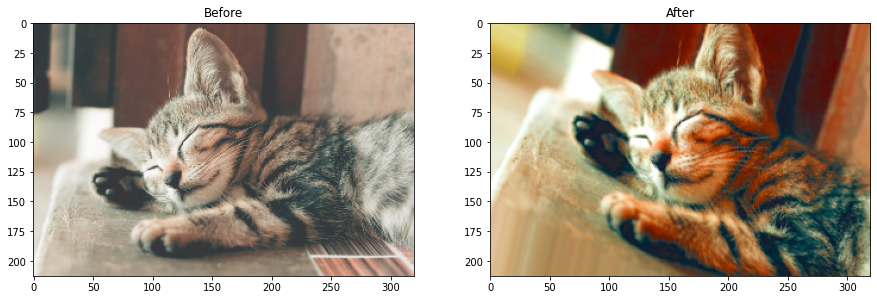

In [ ]:
''' Test ImageAugmentation (before/after plot) '''

gc.collect()
image_augmentor = ImageDataGenerator(
                                    zoom_range = [0.8, 1.1], 
                                    shear_range= 10,
                                    rotation_range=15,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    preprocessing_function=ImgAug.augment,
                                    validation_split=0.2)
image_augmentor_before = ImageDataGenerator()


import requests
DownURL = "https://images.pexels.com/photos/1056251/pexels-photo-1056251.jpeg?crop=entropy&cs=srgb&dl=pexels-ihsan-aditya-1056251.jpg&fit=crop&fm=jpg&h=426&w=640"
img_data = requests.get(DownURL).content

FileHandler.create_dir('/content/sample_data/impath/cat')

with open('/content/sample_data/impath/cat/cat-small.jpg', 'wb') as handler:
    handler.write(img_data)

data_before = image_augmentor_before.flow_from_directory(
    "/content/sample_data/impath",
    target_size=(213, 320),
    batch_size=1,
)
data = image_augmentor.flow_from_directory(
    "/content/sample_data/impath",
    target_size=(213, 320),
    batch_size=1,
)

fig, axs = plt.subplots(1,2, figsize=(15,12))

plt.subplot(axs[0])
plt.imshow(data_before.next()[0][0].astype('int'))
plt.title("Before")

plt.subplot(axs[1])
plt.imshow(data.next()[0][0].astype('int'))
plt.title("After")

In [ ]:
''' Unit Testing '''

Logger.EVALUATION_LOGGING = False

objective_interface = Sphere(10)

abc = ArtificialBeeColony(objective_interface)

abc.optimize()




 [22547.432820331276, 22377.235423088005, 34264.45928373387]
[0.2847307368096651, 0.28258156614639535, 0.43268769704393956] 

0
1
1
2
1
1
1
STATUS: itr: 0 -- Best fitness: 64579.76415445288, Total time (s): 0.27864909172058105


 [30471.270200006005, 33301.36720015647, 64514.92356032946]
[0.23752542643718094, 0.2595854827574742, 0.5028890908053448] 

1
2
2
1
1
2
2
STATUS: itr: 1 -- Best fitness: 64899.020982095564, Total time (s): 0.7251143455505371


 [45139.54111111039, 48068.55320695488, 37030.11248240911]
[0.3465918523026614, 0.36908098740666606, 0.2843271602906725] 

0
1
1
0
2
1
1
STATUS: itr: 2 -- Best fitness: 78222.27769850551, Total time (s): 1.1666624546051025


 [23477.709085288727, 35239.14909191979, 44833.063627461364]
[0.22673149802162237, 0.34031052410469576, 0.4329579778736818] 

2
2
1
1
2
2
1
STATUS: itr: 3 -- Best fitness: 78222.27769850551, Total time (s): 1.981539249420166


 [46989.083375049115, 35239.14909191979, 48552.579073174464]
[0.3592958701974041, 0.269453

KeyboardInterrupt: ignored